In [3]:
using BenchmarkTools
using StellarChem
using StellarConstants
using StellarEOS
using StellarOpacity
using StellarEvolution

In [4]:
    isotope_list = StellarChem.get_isotope_list()

Dict{Symbol, Isotope} with 3352 entries:
  :Ne26  => Isotope(10, 26, "Ne", 26.0005)
  :C22   => Isotope(6, 22, "C", 22.0575)
  :Pr143 => Isotope(59, 143, "Pr", 142.911)
  :Re163 => Isotope(75, 163, "Re", 162.972)
  :Cu52  => Isotope(29, 52, "Cu", 51.9967)
  :Co50  => Isotope(27, 50, "Co", 49.9809)
  :Sr74  => Isotope(38, 74, "Sr", 73.9562)
  :Pt188 => Isotope(78, 188, "Pt", 187.959)
  :No258 => Isotope(102, 258, "No", 258.098)
  :Pb210 => Isotope(82, 210, "Pb", 209.984)
  :Dy148 => Isotope(66, 148, "Dy", 147.927)
  :Hg200 => Isotope(80, 200, "Hg", 199.968)
  :Ir182 => Isotope(77, 182, "Ir", 181.958)
  :Md246 => Isotope(101, 246, "Md", 246.082)
  :Lr251 => Isotope(103, 251, "Lr", 251.094)
  :Cu75  => Isotope(29, 75, "Cu", 74.9415)
  :Ce144 => Isotope(58, 144, "Ce", 143.914)
  :Xe125 => Isotope(54, 125, "Xe", 124.906)
  :Ni66  => Isotope(28, 66, "Ni", 65.9291)
  ⋮      => ⋮

In [5]:
function equationHSE(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                            eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                            κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    if k==sm.nz
        lnP₀ = var00[sm.vari[:lnP]]
        r₀ = exp(var00[sm.vari[:lnr]])
        g₀ = CGRAV*sm.mstar/r₀^2
        return lnP₀ -log(2g₀/(3κ00)) # Eddington gray, ignoring radiation pressure term
    end
    lnP₊ = varp1[sm.vari[:lnP]]
    lnP₀ = var00[sm.vari[:lnP]]
    lnPface = (sm.dm[k]*lnP₀ + sm.dm[k+1]*lnP₊)/(sm.dm[k]+sm.dm[k+1])
    r₀ = exp(var00[sm.vari[:lnr]])
    dm = (sm.m[k+1]-sm.m[k])
    
    return (exp(lnPface)*(lnP₊ - lnP₀)/dm + CGRAV*sm.m[k]/(4π*r₀^4))/(CGRAV*sm.m[k]/(4π*r₀^4))
end

function equationT(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                          eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                          κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    if k==sm.nz
        lnT₀ = var00[sm.vari[:lnT]]
        L₀ = var00[sm.vari[:lum]]*LSUN
        r₀ = exp(var00[sm.vari[:lnr]])
        return lnT₀ - log(L₀/(BOLTZ_SIGMA*4π*r₀^2))/4 # Eddington gray, ignoring radiation pressure term
    end
    κface = exp((sm.dm[k]*log(κ00) + sm.dm[k+1]*log(κp1))/(sm.dm[k]+sm.dm[k+1]))
    L₀ = var00[sm.vari[:lum]]*LSUN
    r₀ = exp(var00[sm.vari[:lnr]])
    Pface = exp((sm.dm[k]*var00[sm.vari[:lnP]] + sm.dm[k+1]*varp1[sm.vari[:lnP]])/(sm.dm[k]+sm.dm[k+1]))
    lnT₊ = varp1[sm.vari[:lnT]]
    lnT₀ = var00[sm.vari[:lnT]]
    Tface = exp((sm.dm[k]*lnT₀ + sm.dm[k+1]*lnT₊)/(sm.dm[k]+sm.dm[k+1]))

    ∇ᵣ = 3κface*L₀*Pface/(16π*CRAD*CLIGHT*CGRAV*sm.m[k]*Tface^4)
    ∇ₐ = (sm.dm[k]*eos00[7] + sm.dm[k+1]*eosp1[7])/(sm.dm[k]+sm.dm[k+1])

    if (∇ᵣ < ∇ₐ)
        return (Tface*(lnT₊ - lnT₀)/sm.dm[k] + CGRAV*sm.m[k]*Tface/(4π*r₀^4*Pface)*∇ᵣ)/(CGRAV*sm.m[k]*Tface/(4π*r₀^4*Pface)) # only radiative transport
    else
        return (Tface*(lnT₊ - lnT₀)/sm.dm[k] + CGRAV*sm.m[k]*Tface/(4π*r₀^4*Pface)*∇ₐ)/(CGRAV*sm.m[k]*Tface/(4π*r₀^4*Pface)) # only radiative transport
    end
end

function equationLuminosity(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                          eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                          κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    L₋::TT = 0 # central luminosity is zero at first cell
    if k>1
        L₋ = varm1[sm.vari[:lum]]*LSUN # change it if not at first cell
    end
    L₀ = var00[sm.vari[:lum]]*LSUN
    ρ₀ = eos00[1]
    cₚ = eos00[5]
    δ = eos00[6]
    dTdt = (exp(var00[sm.vari[:lnT]]) - exp(sm.ssi.lnT_old[k]))/sm.ssi.dt
    dPdt = (exp(var00[sm.vari[:lnP]]) - exp(sm.ssi.lnP_old[k]))/sm.ssi.dt

    ϵnuc = 0.1*var00[sm.vari[:H1]]^2*ρ₀*(exp(var00[sm.vari[:lnT]])/1e6)^4 + 0.1*var00[sm.vari[:H1]]*ρ₀*(exp(var00[sm.vari[:lnT]])/1e7)^18

    return ((L₀-L₋)/sm.dm[k]-ϵnuc+cₚ*dTdt -(δ/ρ₀)*dPdt) # no nuclear reactions or neutrinos
end

function equationContinuity(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                                   eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                                   κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    ρ₀ = eos00[1]
    r₀ = exp(var00[sm.vari[:lnr]])
    r₋::TT = 0 # central radius is zero at first cell
    if k>1
        r₋ = exp(varm1[sm.vari[:lnr]]) # change it if not at first cell
    end
    
    dm = sm.m[k] # this is only valid for k=1
    if k>1
        dm = dm-sm.m[k-1]
    end

    #expected_r₀ = r₋ + dm/(4π*r₋^2*ρ)
    expected_dr³_dm = 3/(4π*ρ₀)
    actual_dr³_dm = (r₀^3-r₋^3)/dm
    
    return (expected_dr³_dm - actual_dr³_dm)*ρ₀
end

#  To test performance, include 8 isotopes similar to basic.net in MESA.
#  of course we are keeping these fixed now, but it lets us test their impact on the
#  computation of the jacobian

function equationH1(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                                    eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                                    κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    ρ₀ = eos00[1]
    ϵnuc = 0.1*var00[sm.vari[:H1]]^2*ρ₀*(exp(var00[sm.vari[:lnT]])/1e6)^4 + 0.1*var00[sm.vari[:H1]]*ρ₀*(exp(var00[sm.vari[:lnT]])/1e7)^18
    rate_per_unit_mass = 4*ϵnuc/((4*isotope_list[:H1].mass-isotope_list[:He4].mass)*AMU*CLIGHT^2)

    Xi = sm.ssi.ind_vars_old[(k-1)*sm.nvars+sm.vari[:H1]]

    return (var00[sm.vari[:H1]]-Xi)/sm.ssi.dt + isotope_list[:H1].mass*AMU*rate_per_unit_mass
end

function equationHe4(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                                    eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                                    κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    return  var00[sm.vari[:He4]] + var00[sm.vari[:H1]] - 1.0
end

equationHe4 (generic function with 1 method)

In [6]:
nvars = 6
nspecies = 2
varnames = [:lnP,:lnT,:lnr,:lum,:H1, :He4]
structure_equations=[equationHSE, equationT,
                        equationContinuity, equationLuminosity,
                        equationH1, equationHe4]
nz = 1000
eos = StellarEOS.IdealEOS(false)
opacity = StellarOpacity.SimpleElectronScatteringOpacity()
sm = StellarModel(varnames, structure_equations, nvars, nspecies, nz, eos, opacity);

In [7]:
# use an n=1 polytrope as initial condition, should be better than a constant density star
using ForwardDiff
using Roots

isotope_list = StellarChem.get_isotope_list()

function theta_n(xi)
    return sin(xi)/xi
end

M = MSUN
R = 100*RSUN
n=1

# create a profile for composition that better resolves edges
function get_logdq(k, nz, logdq_low, logdq_high, numregion)
    if k<numregion
        return logdq_low+(k-1)*(logdq_high - logdq_low)/(numregion-1)
    elseif k<nz-numregion
        return logdq_high
    else
        k0 = nz-numregion
        k1 = nz
        return logdq_high+(logdq_low-logdq_high)*(k-k0)/(k1-k0)
    end
end
logdqs = get_logdq.(1:sm.nz,sm.nz,-3.0,0.0,100)
dqs = 10 .^ logdqs
dqs = dqs./sum(dqs)
dms = dqs.*M
m_face = cumsum(dms)
m_cell = cumsum(dms)
#correct m_center
for i in 1:sm.nz
    if i==1
        m_cell[i] = 0
    elseif i!=sm.nz
        m_cell[i] = m_cell[i] - 0.5*dms[i]
    end
end

rn = R/π # ξ is defined as r/rn, where rn^2=(n+1)Pc/(4π G ρc^2)

ρc = M/(4π*rn^3*(-π^2*ForwardDiff.derivative(theta_n, π)))
Pc = 4π*CGRAV*rn^2*ρc^2/(n+1)

@show ρc, Pc

ξ_cell = zeros(sm.nz)
ξ_face = zeros(sm.nz)
function mfunc(ξ,m)
    return m - 4π*rn^3*ρc*(-(-sin(ξ)+cos(ξ)*ξ))
end

for i in 1:sm.nz
    if i==1
        ξ_cell[i] = 0
    elseif i==sm.nz
        ξ_cell[i] = π
    else
        mfunc_anon = ξ->mfunc(ξ,m_cell[i])
        ξ_cell[i] = find_zero(mfunc_anon, (0,π), Bisection())
    end
    if i==sm.nz
        ξ_face[i] = π
    else
        mfunc_anon = ξ->mfunc(ξ,m_face[i])
        ξ_face[i] = find_zero(mfunc_anon, (0,π), Bisection())
    end
end

#set radii, pressure and temperature, assuming ideal gas without Prad
for i in 1:sm.nz
    μ = 0.5
    XH = 1.0
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnr]] = log(rn*ξ_face[i])
    if i>1
        P = Pc*(theta_n(ξ_cell[i]))^(n+1)
        ρ = ρc*(theta_n(ξ_cell[i]))^(n)
    else
        P = Pc
        ρ = ρc
    end
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnP]] = log(P)
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnT]] = log(P*μ/(CGAS*ρ)) 
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:H1]] = 1.0
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:He4]] = 0
end

#set m and dm
sm.mstar = M
sm.dm = dms
sm.m = m_face

#set luminosity 
for i in 1:sm.nz-1
    μ = 0.5
    Pface = Pc*(theta_n(ξ_face[i]))^(n+1)
    ρface = ρc*(theta_n(ξ_face[i]))^(n)
    Tface = Pface*μ/(CGAS*ρface)
    dlnT = sm.ind_vars[(i)*sm.nvars+sm.vari[:lnT]] - sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnT]]
    dlnP = sm.ind_vars[(i)*sm.nvars+sm.vari[:lnP]] - sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnP]]
    κ=0.2
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lum]] = (dlnT/dlnP)*(16π*CRAD*CLIGHT*CGRAV*m_face[i]*Tface^4)/(3κ*Pface)/LSUN
end

#special cases, just copy values at edges
sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lnP]] = sm.ind_vars[(sm.nz-2)*sm.nvars+sm.vari[:lnP]]
sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lnT]] = sm.ind_vars[(sm.nz-2)*sm.nvars+sm.vari[:lnT]]
sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lum]] = sm.ind_vars[(sm.nz-2)*sm.nvars+sm.vari[:lum]]

(ρc, Pc) = (4.634234999138816e-6, 4.42012112236184e7)


1.9683338318906098e-5

In [8]:
sm.ssi.dt = 100*365.25*24*3600
sm.ssi.lnT_old = zeros(sm.nz)
sm.ssi.lnP_old = zeros(sm.nz)
sm.ssi.ind_vars_old = zeros(sm.nz*sm.nvars)
for i in 1:sm.nz
    sm.ssi.lnT_old[i] = sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnT]]
    sm.ssi.lnP_old[i] = sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnP]]
    sm.ssi.ind_vars_old[(i-1)*sm.nvars+1:i*sm.nvars] .= sm.ind_vars[(i-1)*sm.nvars+1:i*sm.nvars]
end

StellarEvolution.eval_jacobian!(sm)
StellarEvolution.eval_eqs!(sm)

In [9]:
sm.linear_solver.A = sm.jac
sm.linear_solver.b = sm.eqs
corr =solve(sm.linear_solver)

u: 6000-element Vector{Float64}:
 -0.16414643926443198
  0.038380491098563806
  0.06997486234204543
 -0.0003905067384710364
  2.6145232023069716e-21
 -2.6145232023069716e-21
 -0.16422439609154224
  0.03832621387202208
  0.06997019954324919
 -0.0008090809252980981
  ⋮
 -2.9583244010939964e-5
  4.72691120518367e-37
 -4.72691120518367e-37
  1.4640694383815738
 -0.3867700556228901
 -0.08614387436523128
 -2.6790005833175068e-5
  1.5061054442774303e-37
 -1.5061054442774303e-37

In [10]:
using LinearSolve
@benchmark begin
    $sm.linear_solver.A = $sm.jac
    $sm.linear_solver.b = $sm.eqs
    corr =solve($sm.linear_solver)
end

BenchmarkTools.Trial: 1030 samples with 1 evaluation.
 Range (min … max):  4.232 ms …   6.650 ms  ┊ GC (min … max): 0.00% … 22.99%
 Time  (median):     4.590 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.846 ms ± 607.564 μs  ┊ GC (mean ± σ):  4.72% ±  7.77%

    ▁▂▂▄▅█▂▂▁                                                  
  ▄██████████▇█▇▆▅▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▂▂▂▂▃▃▃▄▄▄▃▄▃▄▃▃▄▃▂▃▃▃▂▂▃▃▂▃ ▃
  4.23 ms         Histogram: frequency by time        6.53 ms <

 Memory estimate: 8.73 MiB, allocs estimate: 41.

In [11]:
@benchmark StellarEvolution.eval_jacobian_row!(sm,1)

BenchmarkTools.Trial: 10000 samples with 5 evaluations.
 Range (min … max):  6.462 μs … 542.645 μs  ┊ GC (min … max):  0.00% … 94.59%
 Time  (median):     6.960 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   8.490 μs ±  21.409 μs  ┊ GC (mean ± σ):  12.84% ±  5.04%

   ▃▆██▇▆▄▃▂▁▂▂▁▁▁▁                                           ▂
  ███████████████████████████▆▆▅▅▆▇▇▆▇▆▇▆▇▇▇▆▆▆▆▇▇██▇██▇▇▇▇▆▆ █
  6.46 μs      Histogram: log(frequency) by time      12.8 μs <

 Memory estimate: 25.28 KiB, allocs estimate: 211.

In [12]:
@benchmark StellarEvolution.eval_jacobian!(sm)

BenchmarkTools.Trial: 644 samples with 1 evaluation.
 Range (min … max):  2.377 ms … 39.548 ms  ┊ GC (min … max):  0.00% … 87.32%
 Time  (median):     4.372 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   7.751 ms ±  8.877 ms  ┊ GC (mean ± σ):  42.85% ± 28.43%

    █▅ ▂                                                      
  ▃▄██▇██▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▃▃▂▂ ▂
  2.38 ms        Histogram: frequency by time        33.1 ms <

 Memory estimate: 41.93 MiB, allocs estimate: 456470.

In [13]:
nsteps = 3000
Tcenter = zeros(nsteps)
Pcenter = zeros(nsteps)
Hcenter = zeros(nsteps)
Lsurf = zeros(nsteps)
Rsurf = zeros(nsteps)
Tsurf = zeros(nsteps)
Hsurf = zeros(nsteps)
times = zeros(nsteps)

simtime = 0
dt_next = 1*365.25*24*3600
for k in 1:nsteps
    max_steps = sm.opt.solver.newton_max_iter
    if (k==1)
        max_steps = sm.opt.solver.newton_max_iter_first_step
    end

    sm.ssi.dt = dt_next
    simtime = simtime + sm.ssi.dt
    sm.ssi.lnT_old = zeros(sm.nz)
    sm.ssi.lnP_old = zeros(sm.nz)
    sm.ssi.ind_vars_old = zeros(sm.nz*sm.nvars)
    for i in 1:sm.nz
        sm.ssi.lnT_old[i] = sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnT]]
        sm.ssi.lnP_old[i] = sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnP]]
        sm.ssi.ind_vars_old[(i-1)*sm.nvars+1:i*sm.nvars] .= sm.ind_vars[(i-1)*sm.nvars+1:i*sm.nvars]
    end

    exit_evolution = false
    for i in 1:max_steps
        StellarEvolution.eval_jacobian!(sm)
        StellarEvolution.eval_eqs!(sm)
        
        #if k>2000
            sm.linear_solver.A = sm.jac
            #sm.linear_solver.isfresh = false # cache is already set for sparsity pattern
            sm.linear_solver.b = -sm.eqs
            corr =solve(sm.linear_solver)
        #else
        #    #corr = sm.jac\(-sm.eqs)
        #    corr = sm.jac_BBM\(-sm.eqs)
        #end

        real_max_corr = maximum(corr)
        
        # scale surface correction to prevent negative surface luminosity
        # if correction will produce negative L, scale it so L is halved
        corr_lum_surf = corr[sm.nvars*(sm.nz-1)+sm.vari[:lum]]
        lum_surf = sm.ind_vars[sm.nvars*(sm.nz-1)+sm.vari[:lum]]
        if lum_surf + corr_lum_surf < 0.0
            corr = corr*(-sm.opt.solver.scale_correction_negative_Lsurf*lum_surf/corr_lum_surf)
            #corr[sm.nvars*(sm.nz-1)+sm.vari[:lum]] = corr[sm.nvars*(sm.nz-1)+sm.vari[:lum]]*(-0.1*lum_surf/corr_lum_surf)
        end
        #@show lum_surf, corr_lum_surf, lum_surf + corr_lum_surf

        #scale correction
        if k==1
            corr = corr*min(1,sm.opt.solver.scale_max_correction/maximum(corr))
        else
            corr = corr*min(1,sm.opt.solver.scale_max_correction/maximum(corr))
        end
        if i%50==0
            @show i, maximum(corr), real_max_corr, maximum(sm.eqs)
        end
        # first try applying correction and see if it would give negative luminosity
        sm.ind_vars = sm.ind_vars+corr
        if real_max_corr<1e-10
            if k==1
                println("Found first model")
            end
            if k%100==0
                @show k, i, real_max_corr, maximum(sm.eqs), dt_next/(365.25*24*3600)
            end
            break
        end
        if i == max_steps
            exit_evolution = true
        end
    end

    if (exit_evolution)
        println("Failed to converge, retry")
        break
    end

    Tcenter[k] = exp(sm.ind_vars[(1-1)*sm.nvars+sm.vari[:lnT]])
    Hcenter[k] = exp(sm.ind_vars[(1-1)*sm.nvars+sm.vari[:H1]])
    Pcenter[k] = exp(sm.ind_vars[(1-1)*sm.nvars+sm.vari[:lnP]])
    Lsurf[k] = sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lum]]*LSUN
    Rsurf[k] = exp(sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lnr]])
    Tsurf[k] = exp(sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lnT]])
    Hsurf[k] = exp(sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:H1]])
    times[k] = simtime/(365.25*24*3600)
    if (k==1)
        dt_next = sm.ssi.dt
    else
        ΔR_div_R = abs(Rsurf[k]-Rsurf[k-1])/Rsurf[k]
        ΔTc_div_Tc = abs(Tcenter[k]-Tcenter[k-1])/Tcenter[k]
        ΔX = abs(Hcenter[k]-Hcenter[k-1])/Hcenter[k]

        dt_nextR = dt_next*0.005/ΔR_div_R
        dt_nextTc = dt_next*0.005/ΔTc_div_Tc
        dt_nextX = dt_next*0.005/ΔX

        dt_next = min(2*dt_next, dt_nextR, dt_nextTc, dt_nextX)
    end
end

(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (50, 3.0000000000000004, 5875.517649160513, 151.5267972848451)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (100, 3.0, 5758.213785108949, 147.74957011843617)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (150, 3.0, 5640.27863861399, 143.9919562449959)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (200, 3.0, 5521.682231584813, 140.25381316002313)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (250, 3.0, 5402.433613436234, 136.53499879005358)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (300, 3.0, 5282.527760574542, 132.8353621002925)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (350, 3.0, 5161.946937029145, 129.15475627961678)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (400, 3.0, 5040.706002917941, 125.49302957072905)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (450, 3.0, 4918.785249597278, 121.85002421721765)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (500, 3.0, 4796.176279087317, 118.22558538630074)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (550, 3.0, 4672.894889050372, 114.61954984920703)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (600, 2.9999999999999996, 4548.914747247578, 111.03175154316341)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (650, 3.0, 4424.235296714491, 107.46202400839502)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (700, 3.0, 4298.8639354484485, 103.91019089787369)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (750, 3.0, 4172.779816819964, 100.37607377233144)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (800, 3.0, 4045.982971958976, 96.85949086524124)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (850, 3.0, 3918.4771657568863, 93.36024941703363)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (900, 3.0, 3790.2446089703694, 89.87815313690226)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (950, 3.0, 3661.2841263139885, 86.4129999289944)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1000, 3.0, 3531.599704360638, 82.96457499334065)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1050, 3.0, 3401.1746425460856, 79.53265669833854)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1100, 3.0, 3270.005253029278, 76.11701468111642)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1150, 3.0, 3138.098645577827, 72.71740335564755)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1200, 3.0, 3005.437721447913, 69.33356427864419)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1250, 3.0, 2872.0184687991928, 65.96522598320371)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1300, 3.0, 2737.8440762039977, 62.61209759820122)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1350, 3.0, 2602.9050133314427, 59.273865551513154)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1400, 3.0, 2467.194405312612, 55.950195459598035)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1450, 3.0, 2330.710279697141, 52.64072438986477)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1500, 3.0, 2193.4523220741567, 49.3450528058529)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1550, 3.0, 2055.4101504365112, 46.06274264205422)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1600, 3.0, 1916.5801097525245, 42.793307800202456)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1650, 3.0, 1776.961591677201, 39.536201146955136)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1700, 3.0, 1636.5498800525268, 36.29079809918767)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1750, 3.0000000000000004, 1495.3386353980825, 33.05638070824352)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1800, 3.0, 1353.3245637798052, 29.832107106813055)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1850, 3.0, 1210.5063501048198, 26.61696977394604)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1900, 3.0, 1066.8798644654748, 23.409733487467747)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (1950, 3.0, 922.4403205446196, 20.20884369214764)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (2000, 3.0, 777.1849437183744, 17.01226732602663)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (2050, 2.9999999999999996, 631.1113494533392, 13.817212083551567)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (2100, 3.0, 484.217711448466, 10.619571026254562)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (2150, 3.0, 336.4999917180318, 7.412649426500138)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (2200, 3.0, 187.9561418621688, 4.183365400087496)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (2250, 3.0, 38.58432770431675, 0.8912323417171137)


Found first model


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (100, 4, 2.1793833247720524e-14, 1.1893255269512792e-9, 175.13560570113668)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (200, 4, 1.320140204405741e-14, 7.064702156611702e-10, 250.26851192650622)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (300, 4, 1.3224242969020235e-14, 5.632044830505833e-10, 408.3497309571344)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (400, 4, 1.2087748272672465e-14, 1.8653125710699214e-9, 671.8745549153261)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (500, 4, 1.4653290463962938e-14, 1.1378825659491554e-9, 1106.269944392541)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (600, 4, 1.3519779955441333e-14, 1.0689715779221842e-9, 1821.63056511766)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (700, 4, 1.6752459994207344e-14, 1.6288399518060714e-9, 3000.0033811441344)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (800, 4, 1.5805549687739556e-14, 9.866787387124987e-10, 4969.722280027954)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (900, 4, 2.998766544136148e-11, 1.8093082587711251e-9, 11580.738452485839)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (1000, 4, 4.147230065308026e-15, 5.68495848974563e-10, 1.801976475457304e7)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (1100, 4, 4.772570418815415e-15, 1.0355933542345944e-9, 2.5418105238946203e7)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (1200, 4, 5.952907947049829e-15, 3.153463676817958e-9, 4.212936143040068e6)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (1300, 4, 2.2847299926490233e-12, 2.401528413631393e-9, 422660.8421785523)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (1400, 4, 6.027670174890711e-14, 2.995477782485878e-9, 40832.37725981097)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (1500, 4, 7.477697524213687e-14, 1.7713404354413598e-9, 6961.418732217254)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (1600, 4, 5.186420542472507e-14, 2.9422803915490903e-9, 3021.7761557138015)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (1700, 4, 1.0699068610317495e-13, 3.534340695110494e-9, 1863.8171912037699)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (1800, 4, 2.0916343577541325e-13, 4.834222813721034e-9, 1328.041399665348)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (1900, 4, 1.5002772099605852e-13, 3.299643072662839e-9, 1044.434117200051)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (2000, 4, 1.368402015612325e-13, 3.3684049091653456e-9, 899.6983868701935)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (2100, 4, 1.0058963365482174e-13, 2.049881216159566e-9, 846.604226571959)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (2200, 4, 6.116842045402098e-14, 3.6355301338830692e-9, 847.0866467540765)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (2300, 4, 2.124865724565776e-13, 4.992785299778868e-9, 859.5010840929019)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (2400, 4, 7.85794211441451e-14, 5.689283058551986e-9, 870.286304437191)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (2500, 4, 1.4583235614057206e-13, 5.493628163488751e-9, 889.9739911782842)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (2600, 4, 2.4651065777178115e-13, 4.323697603073051e-9, 938.1516659283119)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (2700, 4, 9.011467340025489e-14, 1.1258784483707263e-8, 1060.9373898352383)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (2800, 4, 3.656485426739103e-13, 5.326693928824067e-9, 1396.5515607709126)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (2900, 4, 2.2939403044122204e-13, 8.092032188419807e-9, 2405.198478391927)


(k, i, real_max_corr, maximum(sm.eqs), dt_next / (365.25 * 24 * 3600)) = (3000, 4, 6.377738435163298e-14, 1.1067202350628462e-8, 5645.727209687207)


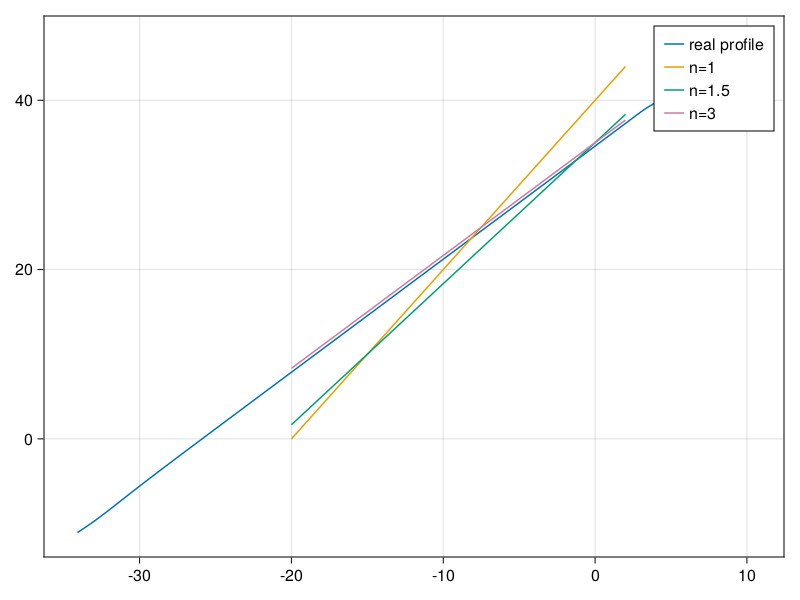

In [14]:
ρprofile = zeros(sm.nz)
for i in 1:sm.nz
    eos_result = get_EOS_resultsTP(sm.eos, sm.isotope_data,
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnT]], sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnP]], [1.0], [:H1])
    ρprofile[i] = eos_result[1]
end

using CairoMakie
f = Figure()
ax = Axis(f[1,1])
lines!(ax, log.(ρprofile), [sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnP]] for i in 1:sm.nz], label="real profile")
xvals = LinRange(-20,2,100)
lines!(ax,xvals,(1+1/1) .* xvals .+ 40, label="n=1")
lines!(ax,xvals,(1+1/(1.5)) .* xvals .+ 35, label="n=1.5")
lines!(ax,xvals,(1+1/3) .* xvals .+ 35, label="n=3")
axislegend(ax)
f

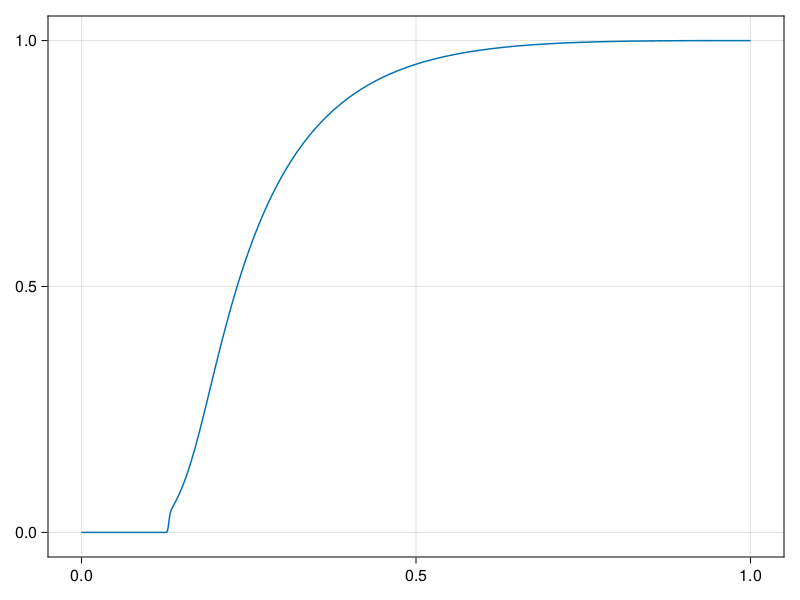

In [15]:
using CairoMakie
f = Figure()
ax = Axis(f[1,1])
lines!(ax, m_face/MSUN, ([sm.ind_vars[(i-1)*sm.nvars+sm.vari[:H1]] for i in 1:sm.nz]))
f

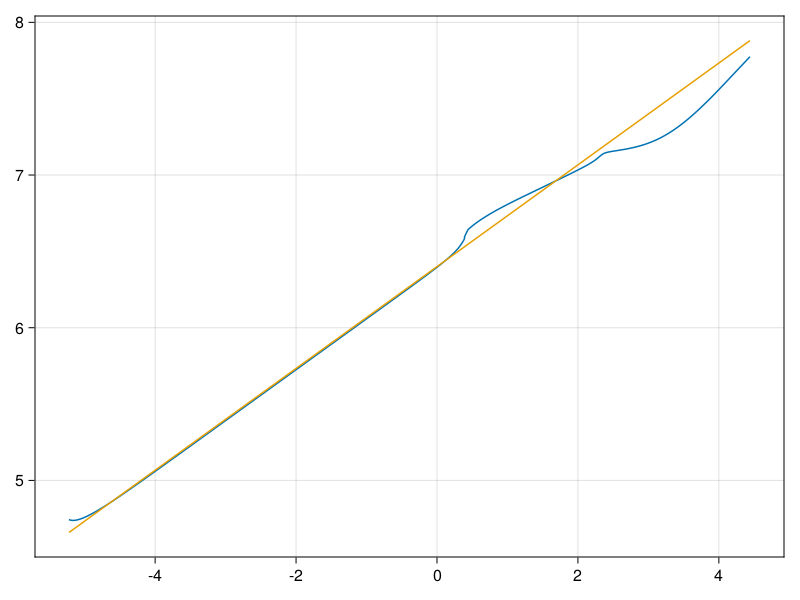

In [16]:
ρcenter = zeros(nsteps)
for i in 1:nsteps
    eos_result = get_EOS_resultsTP(sm.eos, sm.isotope_data,
        log(Tcenter[i]), log(Pcenter[i]), [1.0], [:H1])
    ρcenter[i] = eos_result[1]
end

using CairoMakie
using LaTeXStrings

f = Figure()
ax = Axis(f[1,1], xlabel="")
xvals = collect(LinRange(0,1,1000))
mass = xvals .* MSUN
#lines!(ax, xvals, P_const_ρ(mass,1,MSUN))
#lines!(ax, times, Pcenter)
lines!(ax, log10.(ρcenter), log10.(Tcenter))
lines!(ax, log10.(ρcenter), log10.(ρcenter)./3 .+ 6.4)
#lines!(ax, 1:10000, Lsurf)
#xlims!(ax,930,940)
f

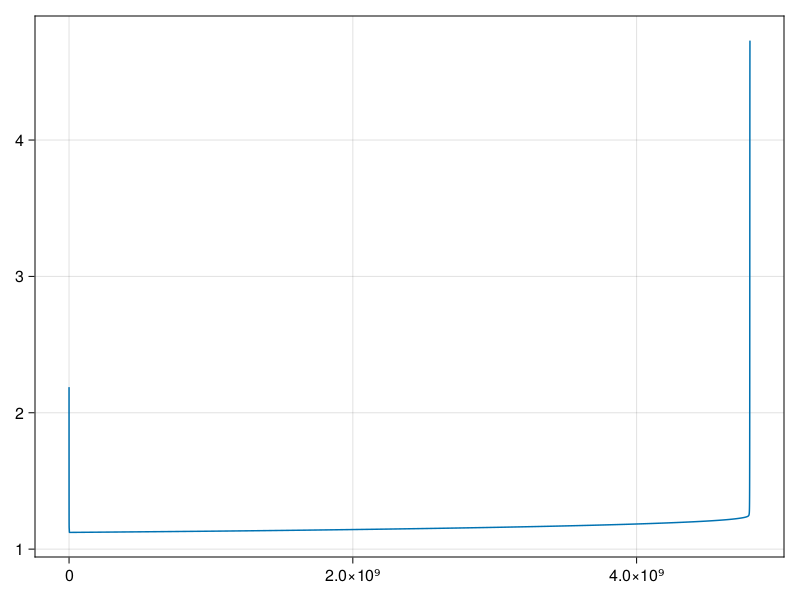

In [17]:
f = Figure()
ax = Axis(f[1,1], xlabel="")
xvals = collect(LinRange(0,1,1000))
mass = xvals .* MSUN
#lines!(ax, xvals, P_const_ρ(mass,1,MSUN))
#lines!(ax, times, Pcenter)
lines!(ax, times, log10.(Rsurf/RSUN)) # not contracting right now?
#lines!(ax, 1:10000, Lsurf)
#xlims!(ax,930,940)
f